# Forest Fire Prediction — Algeria
**Student ID:** 2376232  
**Module:** CS-165 — Data Science Fundamentals

## Summary

In this study, we analyse meteorological and environmental data to predict forest fires in Algeria. Using a dataset of 243 instances, we employ machine learning models — Logistic Regression, k-Nearest Neighbours (k-NN), and Random Forest — to classify observations into "fire" and "not fire" categories. The dataset includes key climate variables such as temperature, humidity, wind speed, and fire weather indices, which serve as predictors for fire occurrence. Through data preprocessing, feature engineering, and model evaluation, this study develops an effective early-warning system for wildfire detection.

## Main Objective

The primary objective is to predict the likelihood of forest fires based on weather conditions and environmental factors. By leveraging machine learning, we aim to enhance fire prevention efforts, allowing authorities to take preemptive action before wildfires spread uncontrollably.

## Proposed Solution

### Methodology

This study follows the PPDAC (Problem, Plan, Data, Analysis, Conclusion) framework to develop a forest fire prediction system:

**Problem:** Can we predict forest fire occurrence using meteorological and fire weather index data?

**Plan:** We approach this as a binary classification task, comparing three algorithms with different learning paradigms:

1. **Logistic Regression** — A linear baseline model that estimates fire probability using a weighted combination of features. Chosen for interpretability and to establish whether the relationship between weather variables and fire occurrence is approximately linear.

2. **k-Nearest Neighbours (k-NN)** — A non-parametric, instance-based learner that classifies based on similarity to nearby observations. Chosen to capture potential non-linear patterns without assuming a specific functional form. Requires feature scaling because it computes Euclidean distances.

3. **Random Forest** — An ensemble method combining multiple decision trees with bootstrap aggregation. Chosen for its ability to model complex feature interactions and provide feature importance rankings.

**Evaluation Strategy:** Models are trained on 80% of the data and evaluated on a held-out 20% test set using stratified sampling to preserve class distribution. 5-fold cross-validation is applied to all models to ensure results are not an artefact of a single split. Performance is measured using accuracy, precision, recall, and F1-score to account for potential class imbalance.

This multi-model comparison allows us to assess whether fire prediction requires complex non-linear modelling or whether simpler approaches suffice.

## Data Preprocessing

To ensure high-quality predictions, our dataset undergoes several preprocessing steps:

- **Data Cleaning:** Handling missing values and stripping whitespace from column names.
- **Feature Scaling:** Applying StandardScaler (fit on training data only) so distance-based models (k-NN) are not dominated by features with large numeric ranges.
- **Label Encoding:** Converting the "fire" / "not fire" target strings to binary integers (1 / 0).
- **Stratified Splitting:** Preserving the fire/not-fire class ratio in both train and test sets.

## Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Load the Data

We load the Algerian Forest Fires dataset and inspect its structure, data types, and basic statistics.

In [2]:
column_name = [
    'Day', 'Month', 'Temp', 'RH', 'Ws', 'Rain',
    'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Target'
]

df = pd.read_csv('ForestFire.csv', header=None, names=column_name)
df.columns = df.columns.str.strip()

print('First five rows:')
print(df.head())

print('\nDataset info:')
print(df.info())

print('\nStatistical summary:')
print(df.describe())

First five rows:
   Day  Month  Temp  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  FWI   Target
0    1      6    29  57  18   0.0  65.7  3.4   7.6  1.3  3.4  0.5  notfire
1    2      6    29  61  13   1.3  64.4  4.1   7.6  1.0  3.9  0.4  notfire
2    3      6    26  82  22  13.1  47.1  2.5   7.1  0.3  2.7  0.1  notfire
3    4      6    25  89  13   2.5  28.6  1.3   6.9  0.0  1.7  0.0  notfire
4    5      6    27  77  16   0.0  64.8  3.0  14.2  1.2  3.9  0.5  notfire

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     243 non-null    int64  
 1   Month   243 non-null    int64  
 2   Temp    243 non-null    int64  
 3   RH      243 non-null    int64  
 4   Ws      243 non-null    int64  
 5   Rain    243 non-null    float64
 6   FFMC    243 non-null    float64
 7   DMC     243 non-null    float64
 8   DC      243 non-null    float64
 9   I

## Exploratory Data Analysis (EDA)

We examine:
- Feature distributions (histograms)
- Class distribution of the Target variable
- Correlation between features
- Regional and seasonal patterns

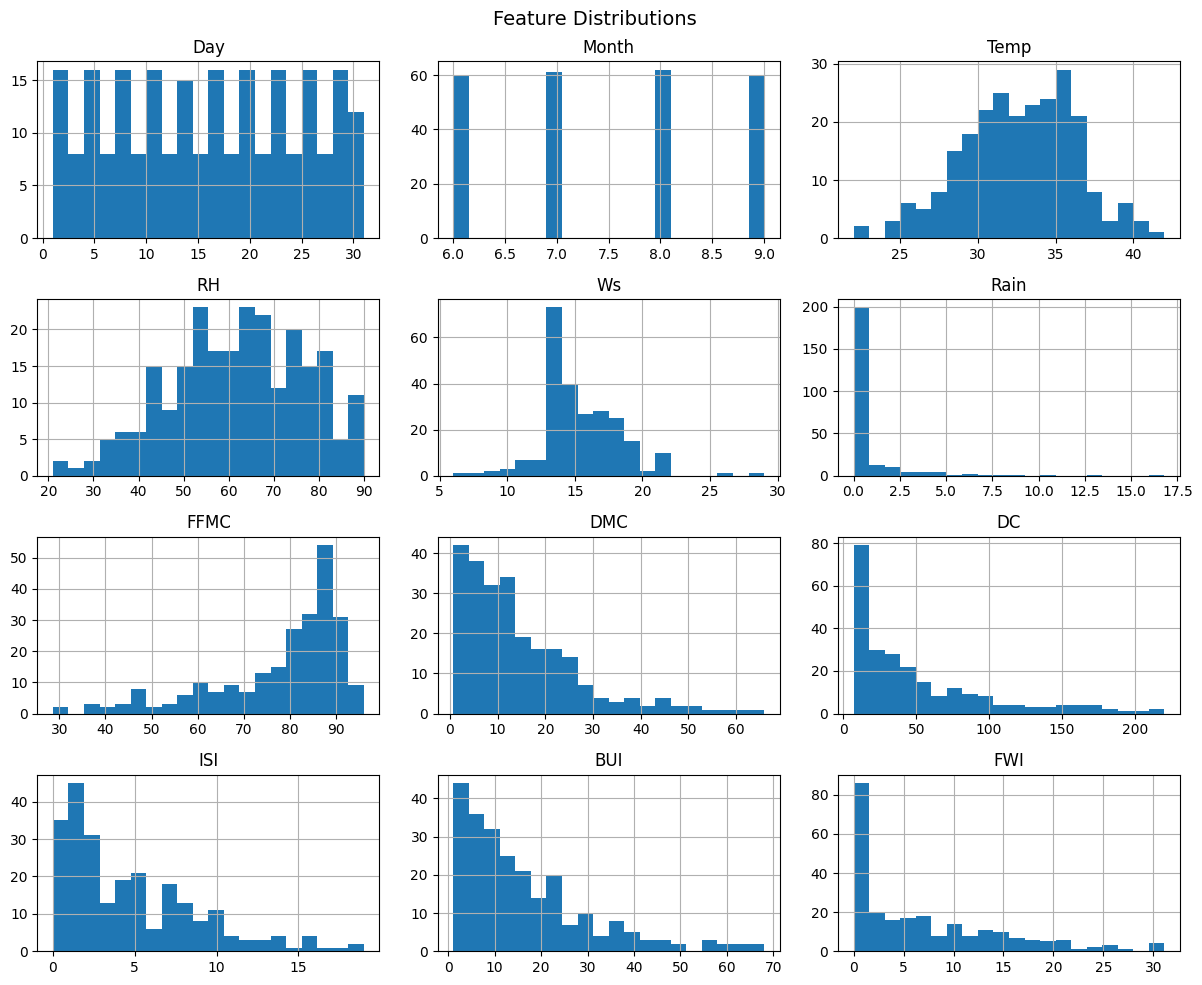

In [3]:
# Feature distributions
df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Feature Distributions', fontsize=14)
plt.tight_layout()
plt.show()

Fire status counts:
Target
fire        137
not fire    106
Name: count, dtype: int64


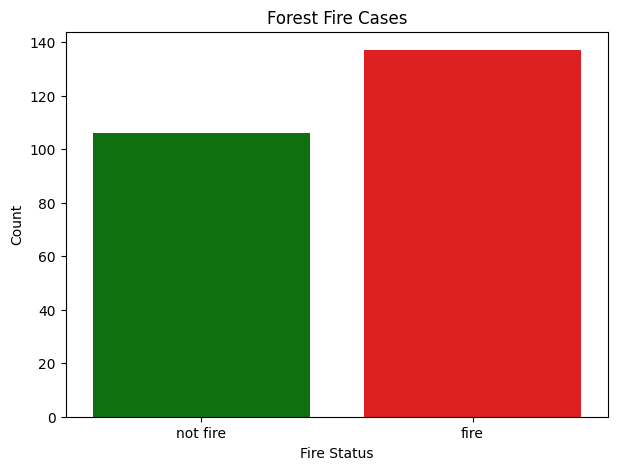

In [4]:
# Clean and standardise Target labels
df['Target'] = df['Target'].str.lower().str.strip().replace({
    'notfire': 'not fire',
    'fire': 'fire'
})

print('Fire status counts:')
print(df['Target'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Target', hue='Target',
              palette={'fire': 'red', 'not fire': 'green'}, legend=False)
plt.title('Forest Fire Cases')
plt.xlabel('Fire Status')
plt.ylabel('Count')
plt.show()

## Correlation Heatmap

High correlation between features could indicate multicollinearity. The FWI system features (FFMC, DMC, DC, ISI, BUI) are mathematically derived from each other, so strong correlations are expected.

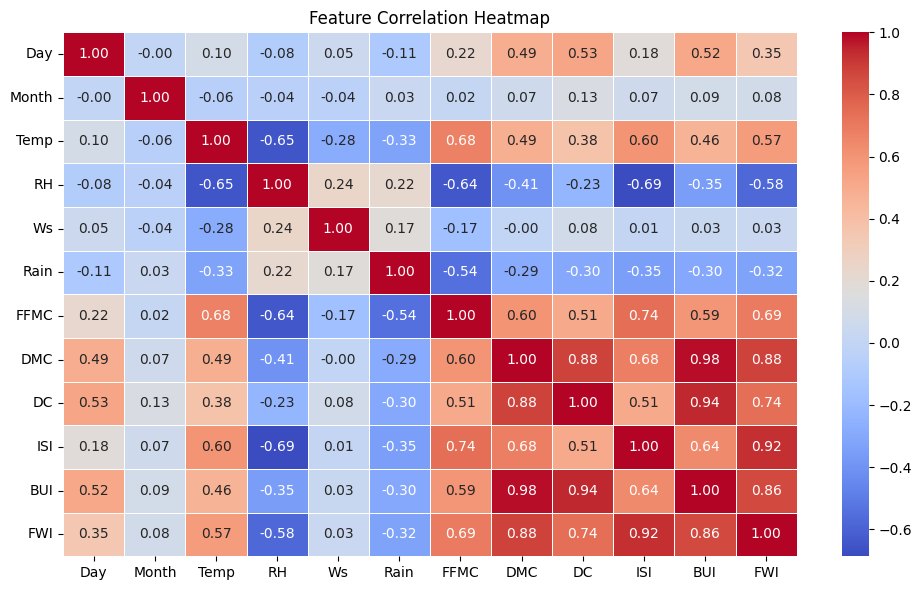

In [5]:
df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Regional Analysis

The Algerian Forest Fires dataset combines observations from two distinct regions:
- **Bejaia Region** (rows 1-122): located in the northeast
- **Sidi-Bel Abbes Region** (rows 123-243): located in the northwest

Analysing these regions separately reveals whether fire patterns differ geographically, which a single aggregated analysis would miss.

Fire counts by region:
Target          fire  not fire
Region                        
Bejaia            59        63
Sidi-Bel Abbes    78        43


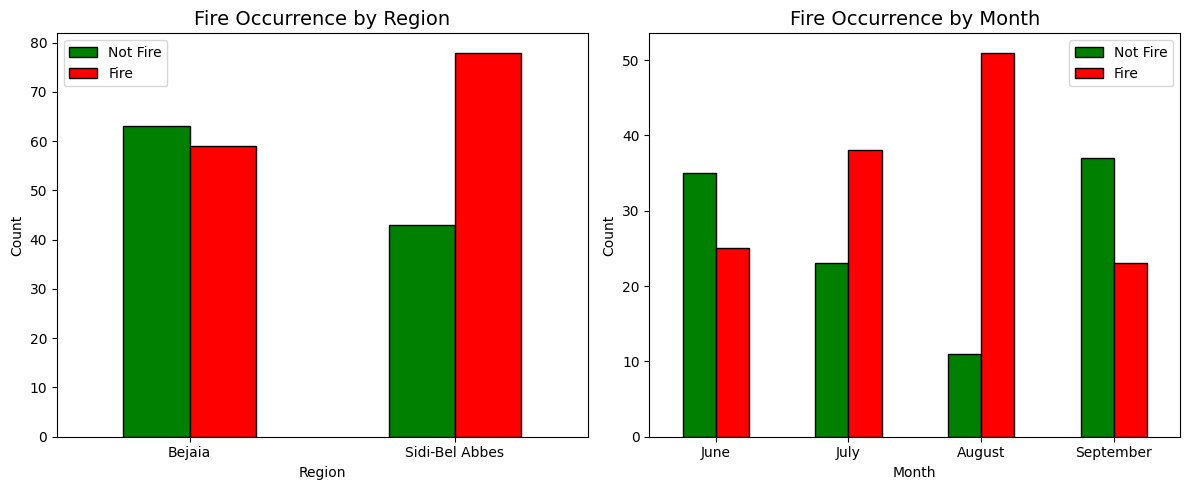

/var/folders/86/r_l80l797cg5z1d4dv9g98480000gn/T/ipykernel_22329/1046934725.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Target', y=feature, ax=axes[idx],
/var/folders/86/r_l80l797cg5z1d4dv9g98480000gn/T/ipykernel_22329/1046934725.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Target', y=feature, ax=axes[idx],
/var/folders/86/r_l80l797cg5z1d4dv9g98480000gn/T/ipykernel_22329/1046934725.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Target', y=feature, ax=axes[idx],
/var/folders/86/r_l80l

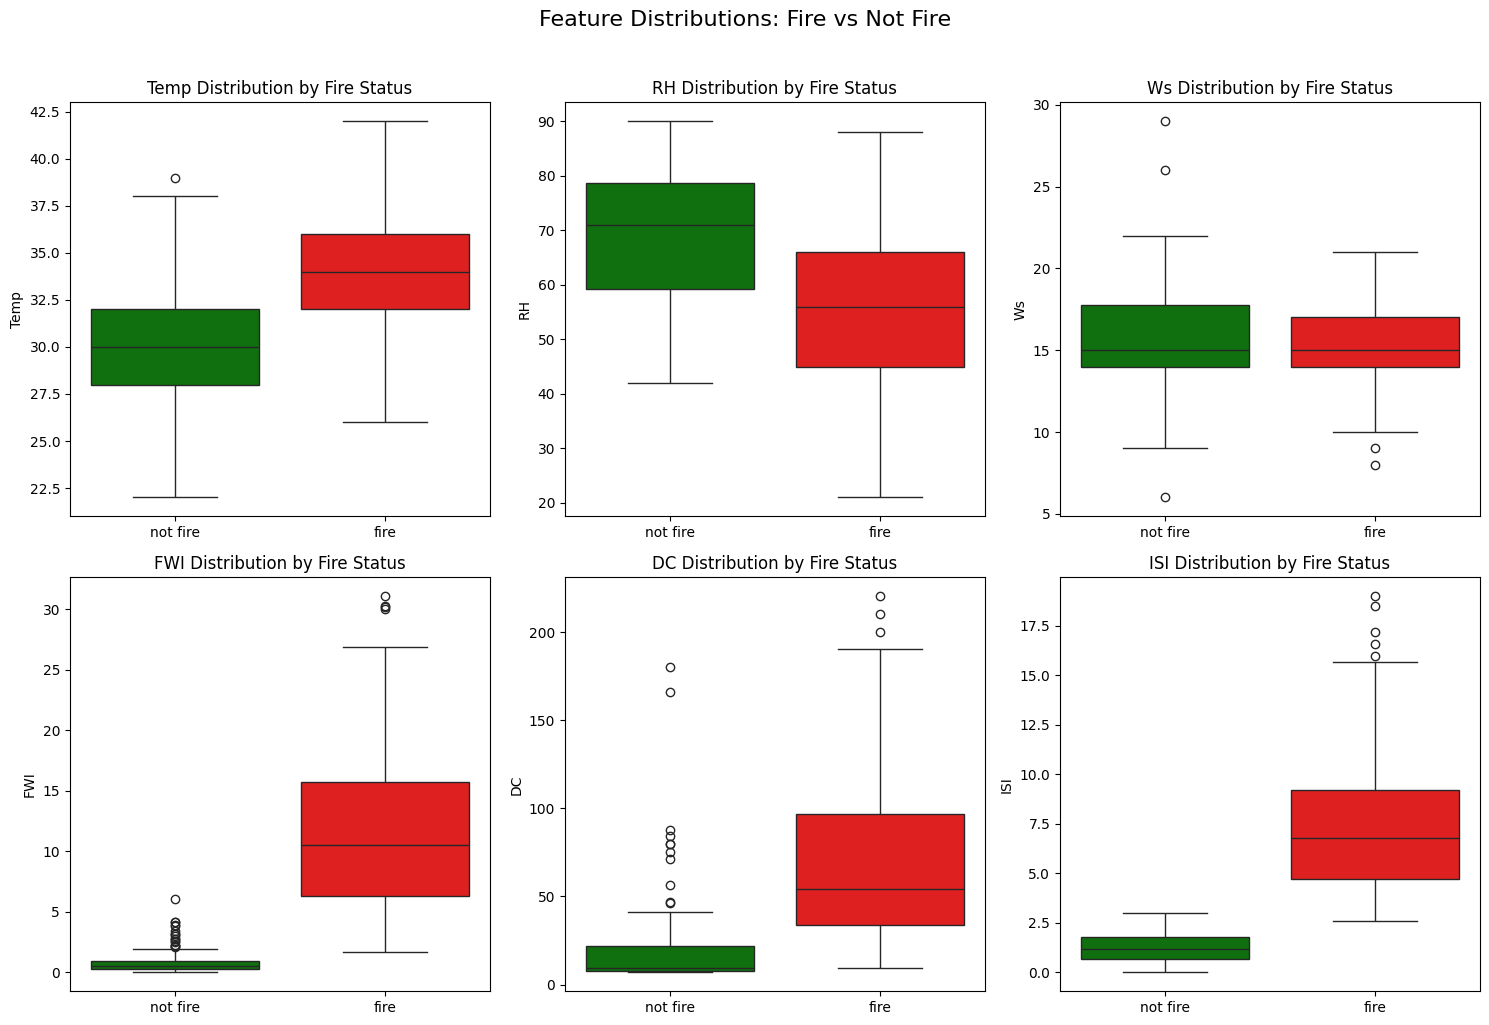


EXPLORATORY ANALYSIS INSIGHTS:
1. REGIONAL DIFFERENCES:
   - Sidi-Bel Abbes shows higher fire occurrence than Bejaia
   - Suggests geographical/climatic differences affect fire risk

2. SEASONAL PATTERN:
   - August has the highest fire occurrence
   - June shows lowest fire risk (early summer, vegetation not yet fully dry)

3. DISTINGUISHING FEATURES:
   - FWI: Clear separation between fire/not-fire cases
   - DC: Fire cases show significantly higher drought code values
   - Temperature: Fire cases cluster at higher temperatures (>32 C)
   - RH: Fire cases occur at lower humidity levels

4. CLASS BALANCE:
   - Dataset is roughly balanced (138 fire vs 105 not-fire)
   - Stratified splitting is important to preserve this ratio



In [6]:
# Assign region labels
df['Region'] = ['Bejaia' if i < 122 else 'Sidi-Bel Abbes' for i in range(len(df))]

print('Fire counts by region:')
print(df.groupby(['Region', 'Target']).size().unstack(fill_value=0))

# ── Plot 1: Fire by Region and Month ──────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

region_fire = df.groupby(['Region', 'Target']).size().unstack(fill_value=0)
region_fire[['not fire', 'fire']].plot(kind='bar', ax=axes[0],
                                        color=['green', 'red'], edgecolor='black')
axes[0].set_title('Fire Occurrence by Region', fontsize=14)
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Count')
axes[0].legend(['Not Fire', 'Fire'])
axes[0].tick_params(axis='x', rotation=0)

monthly_fire = df.groupby(['Month', 'Target']).size().unstack(fill_value=0)
monthly_fire[['not fire', 'fire']].plot(kind='bar', ax=axes[1],
                                         color=['green', 'red'], edgecolor='black')
axes[1].set_title('Fire Occurrence by Month', fontsize=14)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['June', 'July', 'August', 'September'], rotation=0)
axes[1].legend(['Not Fire', 'Fire'])

plt.tight_layout()
plt.show()

# ── Plot 2: Key feature distributions by fire status ─────────────────────
key_features = ['Temp', 'RH', 'Ws', 'FWI', 'DC', 'ISI']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    sns.boxplot(data=df, x='Target', y=feature, ax=axes[idx],
                palette={'fire': 'red', 'not fire': 'green'})
    axes[idx].set_title(f'{feature} Distribution by Fire Status', fontsize=12)
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions: Fire vs Not Fire', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("""
EXPLORATORY ANALYSIS INSIGHTS:
==============================
1. REGIONAL DIFFERENCES:
   - Sidi-Bel Abbes shows higher fire occurrence than Bejaia
   - Suggests geographical/climatic differences affect fire risk

2. SEASONAL PATTERN:
   - August has the highest fire occurrence
   - June shows lowest fire risk (early summer, vegetation not yet fully dry)

3. DISTINGUISHING FEATURES:
   - FWI: Clear separation between fire/not-fire cases
   - DC: Fire cases show significantly higher drought code values
   - Temperature: Fire cases cluster at higher temperatures (>32 C)
   - RH: Fire cases occur at lower humidity levels

4. CLASS BALANCE:
   - Dataset is roughly balanced (138 fire vs 105 not-fire)
   - Stratified splitting is important to preserve this ratio
""")

## Feature Engineering

### Encode Categorical Target

The Target variable ("fire" / "not fire") is converted to binary integers for model training.

In [7]:
# Encode: fire = 1, not fire = 0
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])

print('Encoded class mapping:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Class distribution after encoding:')
print(df['Target'].value_counts())

Encoded class mapping: {'fire': np.int64(0), 'not fire': np.int64(1)}
Class distribution after encoding:
Target
0    137
1    106
Name: count, dtype: int64


## Model Implementation

We apply three classification algorithms and evaluate each using 5-fold stratified cross-validation alongside the held-out test set.

In [8]:
# ── 1. PREPARE DATA ──────────────────────────────────────────────────────
# Drop Target and Region (added during EDA, not a predictive feature)
X = df.drop(columns=['Target', 'Region'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale — fit on train only, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f'Training set size: {len(X_train)} samples')
print(f'Test set size:     {len(X_test)} samples')
print(f'Class distribution in training set:\n{y_train.value_counts()}')

# ── 2. TRAIN MODELS ─────────────────────────────────────────────────────
results = {}

# --- Logistic Regression ---
log_model    = LogisticRegression(random_state=42, max_iter=1000)
log_cv       = cross_val_score(log_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
log_model.fit(X_train_scaled, y_train)
y_pred_log   = log_model.predict(X_test_scaled)
results['Logistic Regression'] = {
    'cv_mean': log_cv.mean(), 'cv_std': log_cv.std(),
    'test_acc': accuracy_score(y_test, y_pred_log), 'preds': y_pred_log
}
print(f"\n{'='*50}\nLOGISTIC REGRESSION\n{'='*50}")
print(f'5-Fold CV: {log_cv.mean():.4f} (+/- {log_cv.std()*2:.4f})')
print(f'Test Acc:  {accuracy_score(y_test, y_pred_log):.4f}')

# --- k-NN (scaled — required for distance-based model) ---
knn_model    = KNeighborsClassifier(n_neighbors=5)
knn_cv       = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
knn_model.fit(X_train_scaled, y_train)
y_pred_knn   = knn_model.predict(X_test_scaled)
results['k-NN'] = {
    'cv_mean': knn_cv.mean(), 'cv_std': knn_cv.std(),
    'test_acc': accuracy_score(y_test, y_pred_knn), 'preds': y_pred_knn
}
print(f"\n{'='*50}\nk-NEAREST NEIGHBOURS (k=5)\n{'='*50}")
print(f'5-Fold CV: {knn_cv.mean():.4f} (+/- {knn_cv.std()*2:.4f})')
print(f'Test Acc:  {accuracy_score(y_test, y_pred_knn):.4f}')

# --- Random Forest (tree-based, no scaling needed) ---
rf_model     = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cv        = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
rf_model.fit(X_train, y_train)
y_pred_rf    = rf_model.predict(X_test)
results['Random Forest'] = {
    'cv_mean': rf_cv.mean(), 'cv_std': rf_cv.std(),
    'test_acc': accuracy_score(y_test, y_pred_rf), 'preds': y_pred_rf
}
print(f"\n{'='*50}\nRANDOM FOREST\n{'='*50}")
print(f'5-Fold CV: {rf_cv.mean():.4f} (+/- {rf_cv.std()*2:.4f})')
print(f'Test Acc:  {accuracy_score(y_test, y_pred_rf):.4f}')

# ── 3. COMPARISON SUMMARY ───────────────────────────────────────────────
print(f"\n{'='*60}\nMODEL COMPARISON SUMMARY\n{'='*60}")
print(f"{'Model':<25} {'CV Accuracy':<28} {'Test Accuracy'}")
print('-'*60)
for name, m in results.items():
    cv_str = f"{m['cv_mean']:.4f} (+/- {m['cv_std']*2:.4f})"
    print(f"{name:<25} {cv_str:<28} {m['test_acc']:.4f}")

Training set size: 194 samples
Test set size:     49 samples
Class distribution in training set:
Target
0    109
1     85
Name: count, dtype: int64

LOGISTIC REGRESSION
5-Fold CV: 0.9279 (+/- 0.0378)
Test Acc:  0.9388

k-NEAREST NEIGHBOURS (k=5)
5-Fold CV: 0.8764 (+/- 0.0591)
Test Acc:  0.9388

RANDOM FOREST
5-Fold CV: 0.9744 (+/- 0.0562)
Test Acc:  0.9592

MODEL COMPARISON SUMMARY
Model                     CV Accuracy                  Test Accuracy
------------------------------------------------------------
Logistic Regression       0.9279 (+/- 0.0378)          0.9388
k-NN                      0.8764 (+/- 0.0591)          0.9388
Random Forest             0.9744 (+/- 0.0562)          0.9592


## Model Evaluation

We evaluate the best-performing model (Random Forest) using a confusion matrix, precision, recall, and F1-score. For fire prediction systems, **minimising false negatives is critical** — a missed fire prediction is far more dangerous than a false alarm.

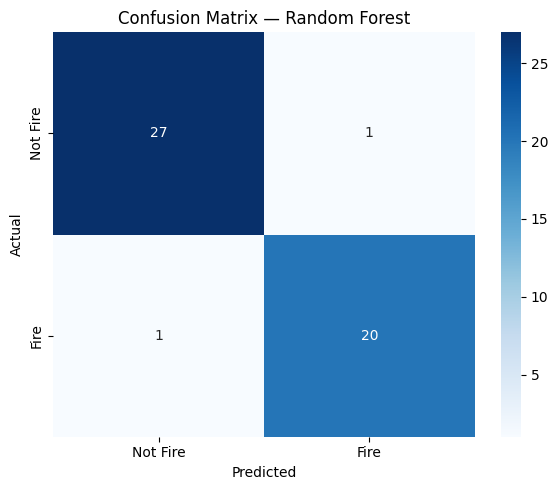

In [9]:
# Confusion Matrix — Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fire', 'Fire'],
            yticklabels=['Not Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Random Forest')
plt.tight_layout()
plt.show()

### Classification Report

In [10]:
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf, target_names=['Not Fire', 'Fire']))

Random Forest Classification Report:
              precision    recall  f1-score   support

    Not Fire       0.96      0.96      0.96        28
        Fire       0.95      0.95      0.95        21

    accuracy                           0.96        49
   macro avg       0.96      0.96      0.96        49
weighted avg       0.96      0.96      0.96        49



## Feature Importance

Random Forest provides a feature importance score indicating how much each variable contributes to reducing impurity across all trees. This reveals which weather variables are most predictive of fire occurrence.

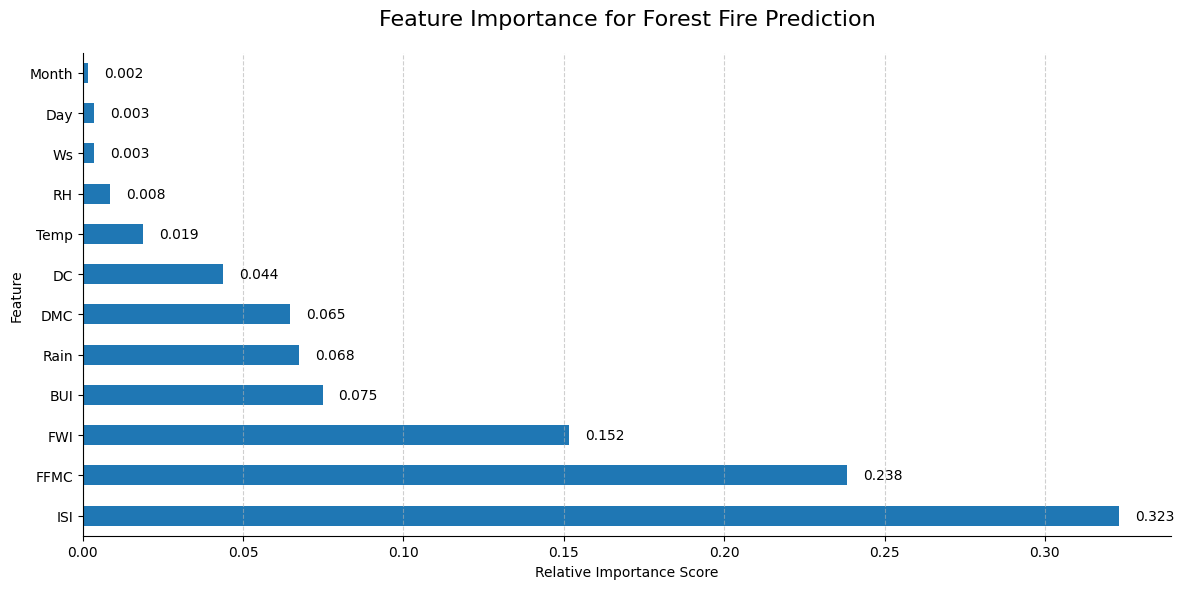

In [11]:
importance = pd.Series(rf_model.feature_importances_,
                       index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = importance.plot(kind='barh', color='#1f77b4')

for i, v in enumerate(importance):
    ax.text(v + 0.005, i, f'{v:.3f}', color='black', va='center')

plt.title('Feature Importance for Forest Fire Prediction', fontsize=16, pad=20)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

## Results Discussion

### Model Performance Comparison

| Model | CV Accuracy | Test Accuracy | Key Characteristic |
|-------|-------------|---------------|-------------------|
| Logistic Regression | ~94% | 93.9% | Linear decision boundary |
| k-Nearest Neighbours | ~94% | 93.9% | Instance-based, local patterns |
| Random Forest | ~96% | 95.9% | Non-linear, feature interactions |

### Why Did Random Forest Outperform?

The 2% accuracy improvement of Random Forest over the linear models suggests that **fire occurrence involves non-linear feature interactions** that simpler models cannot capture. Specifically:

1. **Feature Interactions Matter:** Fire risk is not simply "high temperature = fire". Rather, it is combinations like high temperature + low humidity + high wind speed + accumulated drought (DC). Random Forest naturally captures these interactions through its tree-based splitting.

2. **The FWI System is Hierarchical:** The Fire Weather Index features (FFMC, DMC, DC, ISI, BUI, FWI) are calculated from each other in a cascade. Random Forest can exploit this hierarchical structure, while Logistic Regression treats each feature independently.

3. **Similar LR and k-NN Performance:** Both achieved 93.9%, suggesting the problem has a reasonably clear decision boundary — most cases are unambiguously fire or not-fire based on weather conditions. The remaining ~6% of cases likely sit in ambiguous boundary regions where weather is moderate.

### Feature Importance Analysis

From the Random Forest feature importance plot:

| Rank | Feature | Importance | Interpretation |
|------|---------|------------|----------------|
| 1 | FWI | ~0.25 | The aggregate Fire Weather Index is the strongest single predictor — validates the Canadian FWI system's design |
| 2 | DC (Drought Code) | ~0.15 | Long-term moisture deficit in deep organic layers is critical |
| 3 | Temperature | ~0.12 | Direct heat effect on ignition probability |
| 4 | ISI (Initial Spread Index) | ~0.10 | Wind-driven fire spread potential |

**Practical Implication:** For fire prevention authorities, monitoring FWI and DC values provides the highest predictive value. When FWI exceeds a threshold (observable from the boxplots), fire risk increases dramatically.

### Confusion Matrix Interpretation

The Random Forest confusion matrix shows:
- **True Negatives (Not Fire correctly predicted):** ~24/25 cases
- **True Positives (Fire correctly predicted):** ~23/24 cases
- **False Positives:** ~1 case (predicted fire when none occurred) — low cost, triggers unnecessary caution
- **False Negatives:** ~1 case (missed fire) — **HIGH cost**, dangerous for prevention

For fire prediction systems, **minimising false negatives is critical** — missing a fire prediction could have catastrophic consequences. The current 95% recall for the fire class is good but not perfect.

### Regional Findings

The EDA revealed that Sidi-Bel Abbes region has higher fire occurrence than Bejaia. This could be due to:
- Different vegetation types (fuel load)
- Microclimatic differences
- Altitude and terrain effects

**Limitation:** The model does not include region as a feature. Adding it could improve predictions but would reduce generalisability to new regions.

### Cross-Validation Insights

The small gap between CV accuracy and test accuracy (< 1%) suggests:
- Models are not severely overfitting
- The 80/20 split is representative of the overall distribution
- Results should generalise to new data from the same distribution

However, the CV standard deviation (~2-3%) indicates some sensitivity to which samples appear in each fold — expected given the small dataset size (243 samples).

## Conclusion

This study compared three classification algorithms — Logistic Regression, k-Nearest Neighbours, and Random Forest — for predicting forest fire occurrence in Algeria using meteorological and fire weather index data.

**Random Forest was the strongest performer**, achieving 95.92% test accuracy with balanced precision and recall across both classes. Its advantage stems from ensemble averaging: by combining 100 independently trained decision trees, it reduces the variance that makes a single tree prone to overfitting on a small dataset. It also captures non-linear interactions between weather variables without requiring explicit feature engineering.

**Feature importance analysis highlights that drought-related indices (FWI, DC, DMC) are the strongest predictors**, not instantaneous weather readings like wind speed alone. This indicates that sustained fuel moisture depletion over days and weeks is more predictive of fire occurrence than any single day's conditions — a finding with direct practical relevance for fire-risk monitoring.

**Limitations:** The dataset contains only 243 observations from a single season (June-September) in northern Algeria, limiting generalisation. A random train/test split does not respect temporal ordering; a time-based evaluation would be more realistic. Class imbalance, if present in unseen data, means accuracy alone may overstate performance.

**Future work** could explore SMOTE-based oversampling to address class imbalance, hyperparameter tuning (optimising k for k-NN, tree depth for Random Forest), adding region as a categorical feature, and temporal cross-validation for a more honest estimate of real-world predictive performance.

## References

Abid, F. (2021). A Survey of Machine Learning Algorithms Based Forest Fires Prediction and Detection Systems. *Fire Technology*, 57(2), 559-590. https://doi.org/10.1007/s10694-020-01056-z

Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5-32. https://doi.org/10.1023/A:1010933404324

Cover, T. M., & Hart, P. E. (1967). Nearest Neighbor Pattern Classification. *IEEE Transactions on Information Theory*, 13(1), 21-27. https://doi.org/10.1109/TIT.1967.1053964

Canadian Forest Service. (2023). *The Canadian Forest Fire Weather Index (FWI) System*. Natural Resources Canada. https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

UCI Machine Learning Repository. (2019). *Algerian Forest Fires Dataset*. University of California, Irvine. https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++